<a href="https://colab.research.google.com/github/sarogithubacc/TNSDC-GEN-AI/blob/main/IMAGECOLOURING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal

In [7]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/landscape Images/'
num_images = 1000

color_paths = sorted(glob(path + "color/" + "*.jpg"))[:num_images]
gray_paths = sorted(glob(path + "gray/" +"*.jpg"))[:num_images]

images = np.zeros(shape=(len(color_paths), 256, 256, 3))
masks = np.zeros(shape=(len(gray_paths), 256, 256, 3))

i = 0
for color_path, gray_path in zip(color_paths, gray_paths):

    image = tf.cast(img_to_array(load_img(color_path)), tf.float32)
    mask = tf.cast(img_to_array(load_img(gray_path)), tf.float32)

    images[i] = (tf.image.resize(image,(256,256)))/255.
    masks[i] = (tf.image.resize(mask,(256,256)))/255.

    i += 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


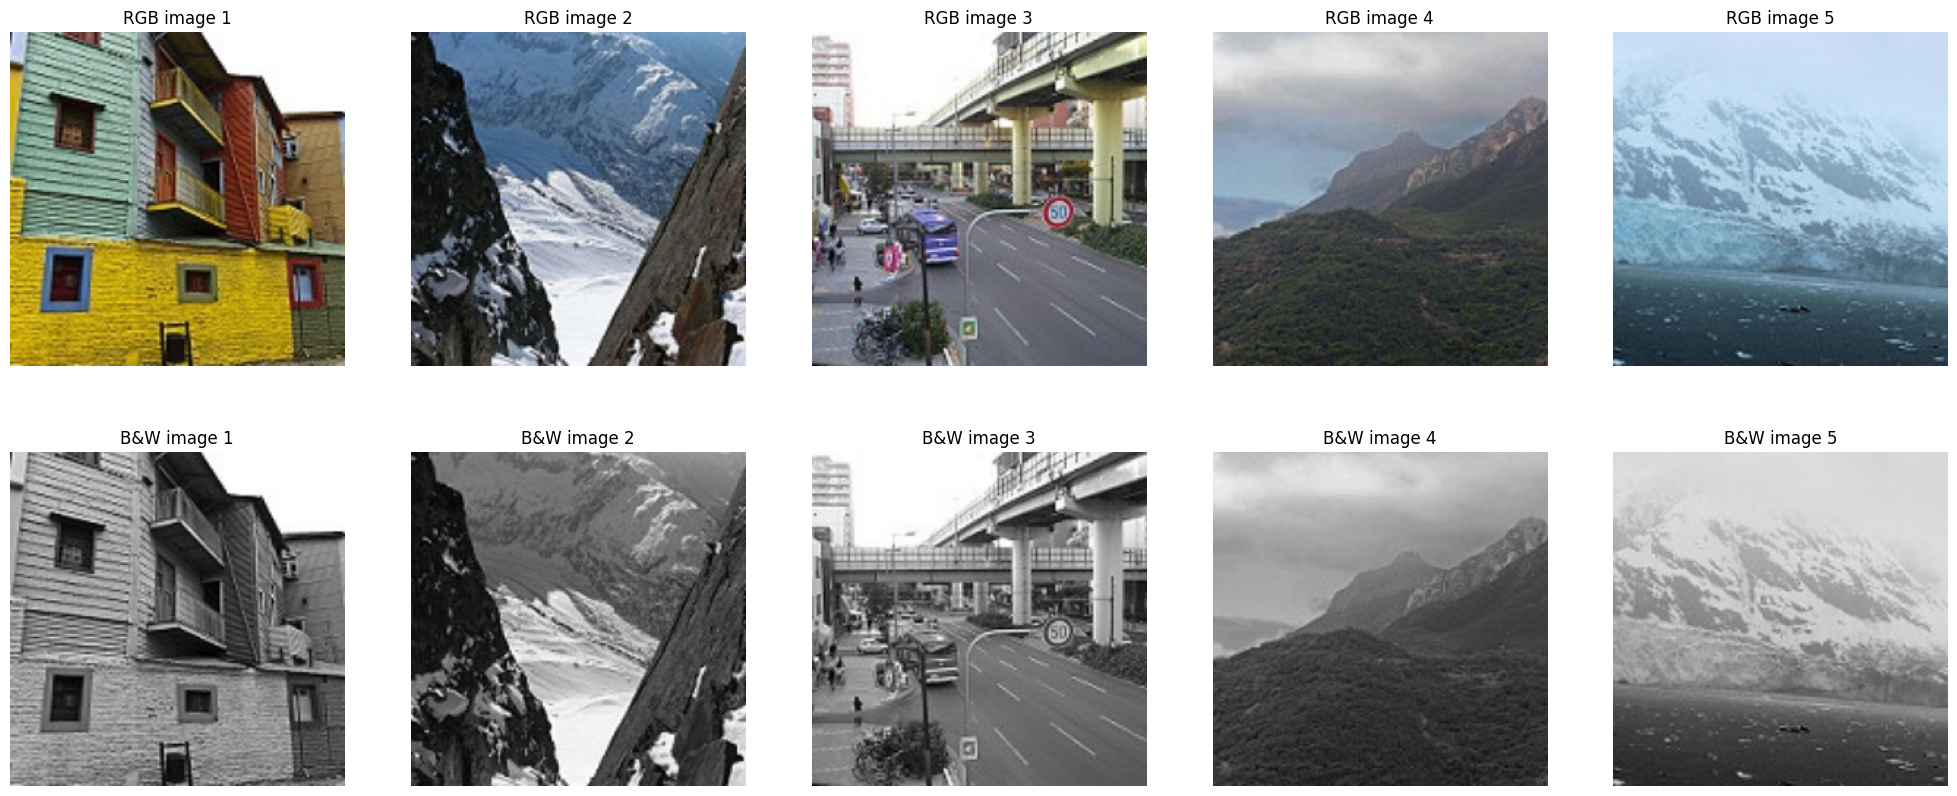

In [8]:
plt.figure(figsize=(25,10))
for i in range(1,6):
    image, mask = images[i], masks[i]
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title("RGB image " + str(i))
    plt.axis("off")

    plt.subplot(2,5,i + 5)
    plt.imshow(mask)
    plt.title("B&W image " + str(i))
    plt.axis("off")
plt.show()

In [9]:
def downscale(num_filters):
    block = Sequential()
    block.add(Conv2D(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    return block

def upscale(num_filters):
    block = Sequential()
    block.add(Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    block.add(ReLU())
    return block

def Generator():
    inputs = Input(shape=(256,256,3), name="InputLayer")

    encoder = [
        downscale(64),
        downscale(128),
        downscale(256),
        downscale(512),
        downscale(512),
        downscale(512),
        downscale(512),
    ]

    latent_space = downscale(512)

    decoder = [
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(256),
        upscale(128),
        upscale(64),
    ]

    x = inputs
    skips = []
    for layer in encoder:
        x = layer(x)
        skips.append(x)

    x = latent_space(x)

    skips = reversed(skips)
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = concatenate([x, skip])

    initializer = RandomNormal(stddev=0.02, seed=42)
    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, kernel_initializer = initializer, activation = 'tanh', padding = 'same')

    outputs = outputs(x)

    generator = Model(inputs = inputs, outputs = outputs, name="Generator")
    return generator

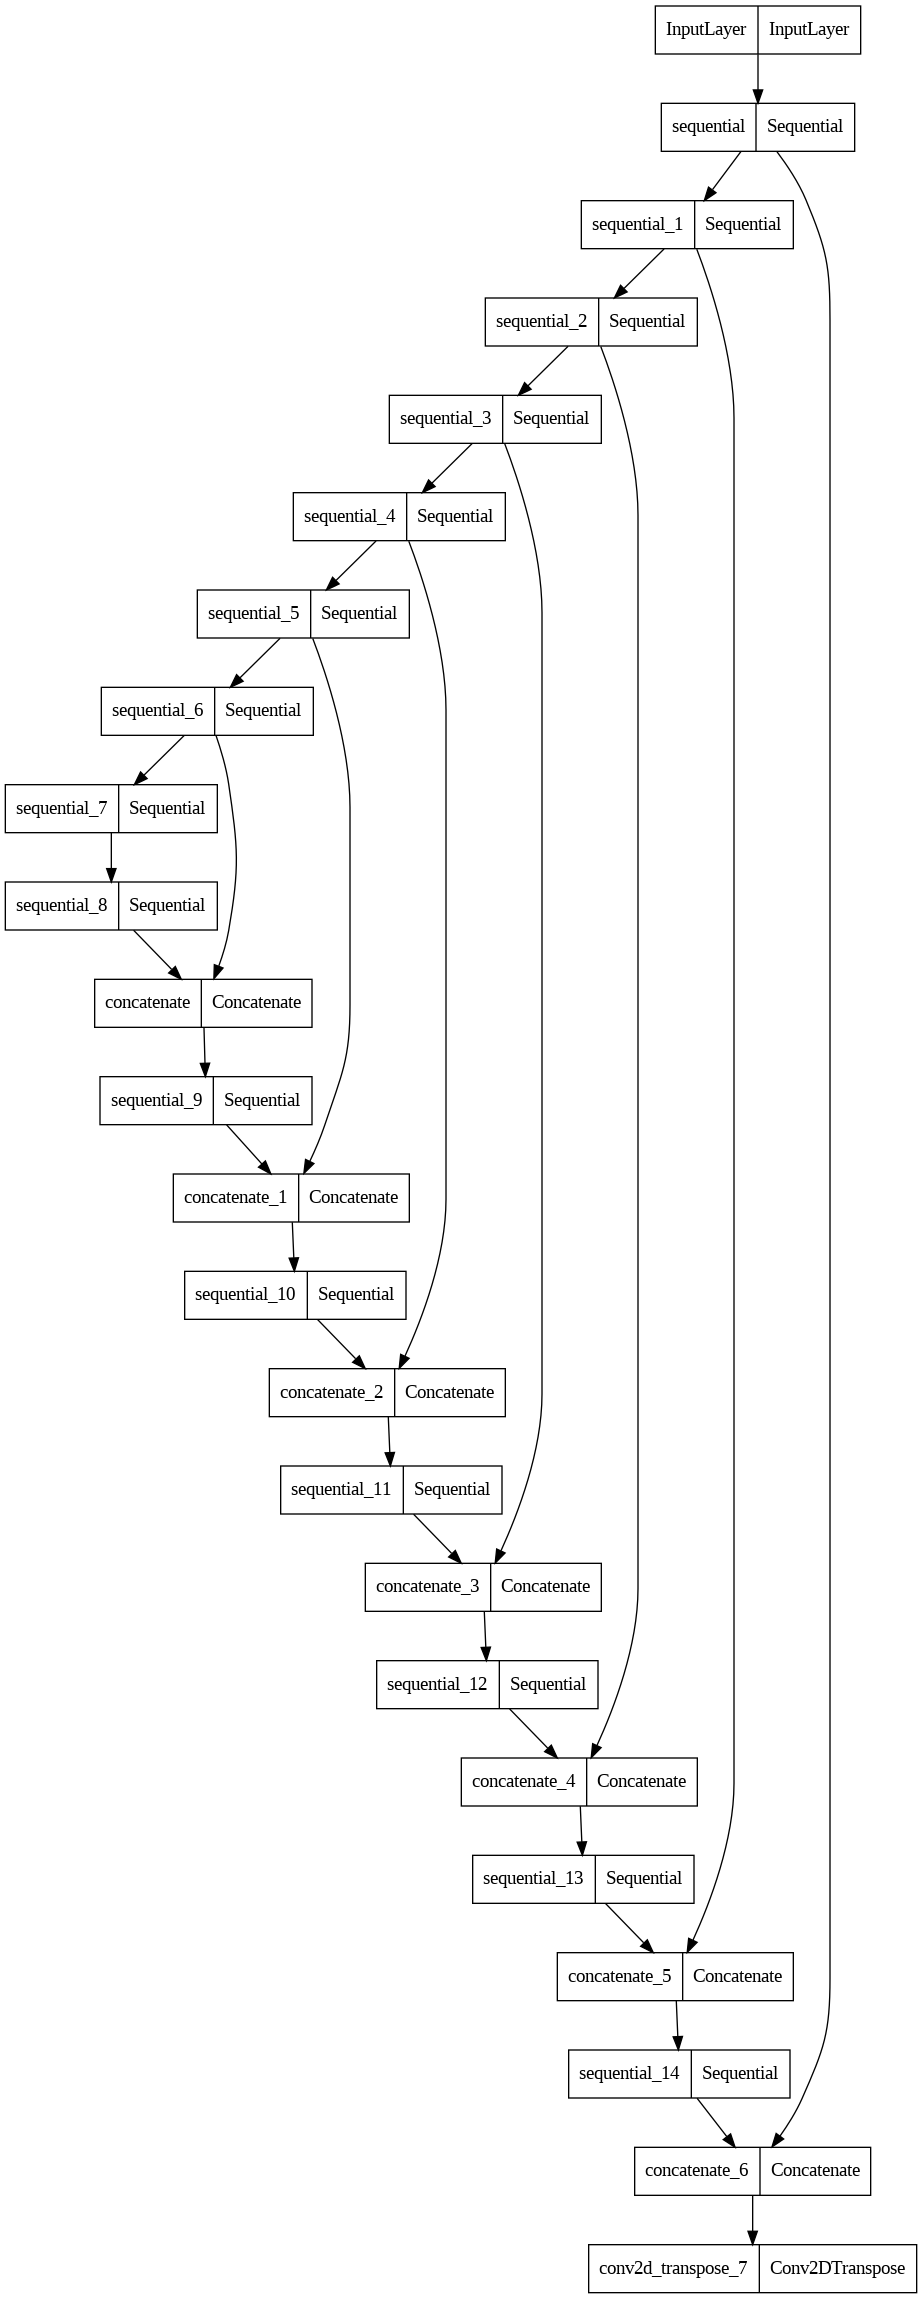

In [10]:
generator = Generator()
plot_model(generator)

In [11]:
def Discriminator():
    image = Input(shape = (256,256,3), name = "ImageInput")
    target = Input(shape = (256,256,3), name = "TargetInput")
    x = concatenate([image, target])

    x = downscale(64)(x)
    x = downscale(128)(x)
    x = downscale(512)(x)

    initializer = RandomNormal(stddev = 0.02, seed=42)

    x = Conv2D(512, kernel_size = 4, strides = 1, kernel_initializer = initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, kernel_size = 4, kernel_initializer = initializer)(x)

    discriminator = Model(inputs = [image, target], outputs = x, name = "Discriminator")

    return discriminator

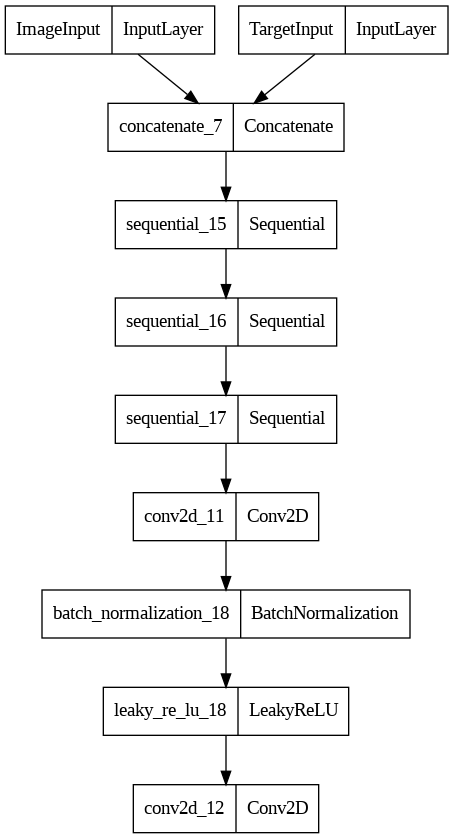

In [12]:
discriminator = Discriminator()
plot_model(discriminator)

In [13]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(discriminator_generated, generated_output, target_image):
    gan_loss = adversarial_loss(tf.ones_like(discriminator_generated), discriminator_generated)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_output))
    total_loss = (100 * l1_loss) + gan_loss
    return total_loss, gan_loss, l1_loss

def discriminator_loss(discriminator_real_output, discriminator_generated_output):
    real_loss = adversarial_loss(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = adversarial_loss(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

def train_step(inputs, target):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_output = generator(inputs, training=True)

        discriminator_real_output = discriminator([inputs, target], training=True)
        discriminator_generated_output = discriminator([inputs, generated_output], training=True)

        generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generated_output, target)

        discriminator_Loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)

    generator_gradients = generator_tape.gradient(generator_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    discriminator_gradients = discriminator_tape.gradient(discriminator_Loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [14]:
def fit(data, epochs):
  for epoch in range(epochs):
    start = time.time()
    print("Current epoch: ", epoch+1)
    for image, mask in data:
      train_step(image, mask)
    print(f"Time taken to complete the epoch {epoch + 1} is {(time.time() - start):.2f} seconds \n")

In [3]:
rgb, gray = tf.cast(images, tf.float32), tf.cast(masks, tf.float32)
dataset = (gray,rgb)
data = tf.data.Dataset.from_tensor_slices(dataset).batch(32, drop_remainder=True)

NameError: name 'tf' is not defined

In [2]:
fit(data, 100)

NameError: name 'fit' is not defined

In [ ]:
def show_predictions(num_samples):
    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]

        plt.figure(figsize=(10,8))

        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Color Image " + str(i + 1))
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("B/W Image " + str(i + 1))
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(i + 1))
        plt.axis('off')

        plt.show()

In [ ]:
show_predictions(5)